# NX-421 Mini-Project 1 — Part 2

In [1]:
import os
import os.path as op
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import plotting
from nilearn.datasets import load_mni152_template
from nilearn.maskers import NiftiMasker
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [2]:
# Define paths
PREPROC_DATA_ROOT = op.abspath('derivatives/preprocessed_data')
OUTPUT_DIR = op.abspath('kmeans_results')
os.makedirs(OUTPUT_DIR, exist_ok=True)
FUNC_IMG = op.join(PREPROC_DATA_ROOT, 'sub-101410_task-motor_concat_bold.nii.gz')

## Load functional image and apply brain mask

In [3]:
fmri_img = nib.load(FUNC_IMG)
TR = float(fmri_img.header.get_zooms()[-1])
n_volumes = fmri_img.shape[-1]

print(f'Shape: {fmri_img.shape}')
print(f'TR: {TR}s')
print(f'Number of volumes: {n_volumes}')

# Apply brain mask
masker = NiftiMasker(
    standardize=False,
    detrend=False,
    smoothing_fwhm=None,
    t_r=TR,
    memory='nilearn_cache',
    memory_level=1,
    verbose=0
)
fmri_masked = masker.fit_transform(fmri_img)

Shape: (91, 109, 91, 568)
TR: 1.0s
Number of volumes: 568


## Select best number of clusters

In [4]:
# Test range of K values
k_range = range(2, 8)
metrics = {
    'K': [],
    'Inertia': [],
    'Silhouette': [],
    'Calinski-Harabasz': [],
    'Davies-Bouldin': []
}

for k in k_range:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(fmri_masked)
    
    metrics['K'].append(k)
    metrics['Inertia'].append(kmeans.inertia_)
    metrics['Silhouette'].append(silhouette_score(
        fmri_masked, labels, sample_size=min(10000, fmri_masked.shape[0])))
    metrics['Calinski-Harabasz'].append(calinski_harabasz_score(fmri_masked, labels))
    metrics['Davies-Bouldin'].append(davies_bouldin_score(fmri_masked, labels))
    
    print(f'K={k:2d}: Silhouette={metrics["Silhouette"][-1]:.3f}, '
            f'CH={metrics["Calinski-Harabasz"][-1]:.1f}, '
            f'DB={metrics["Davies-Bouldin"][-1]:.3f}')

metrics_df = pd.DataFrame(metrics)
metrics_df

K= 2: Silhouette=0.617, CH=1638.7, DB=0.585
K= 3: Silhouette=0.378, CH=891.0, DB=1.868
K= 4: Silhouette=0.110, CH=628.5, DB=2.660
K= 5: Silhouette=0.348, CH=463.9, DB=2.521
K= 6: Silhouette=0.068, CH=396.5, DB=3.343
K= 7: Silhouette=0.071, CH=335.2, DB=3.289


,K,Inertia,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,2,1759048.125,0.617490,1638.723268,0.584953
1,3,1649518.250,0.378070,890.981913,1.867714
2,4,1577716.000,0.110258,628.477181,2.660458
3,5,1594996.500,0.348261,463.899694,2.520933
4,6,1513458.000,0.068099,396.474604,3.343451
5,7,1494311.250,0.071377,335.231783,3.289031


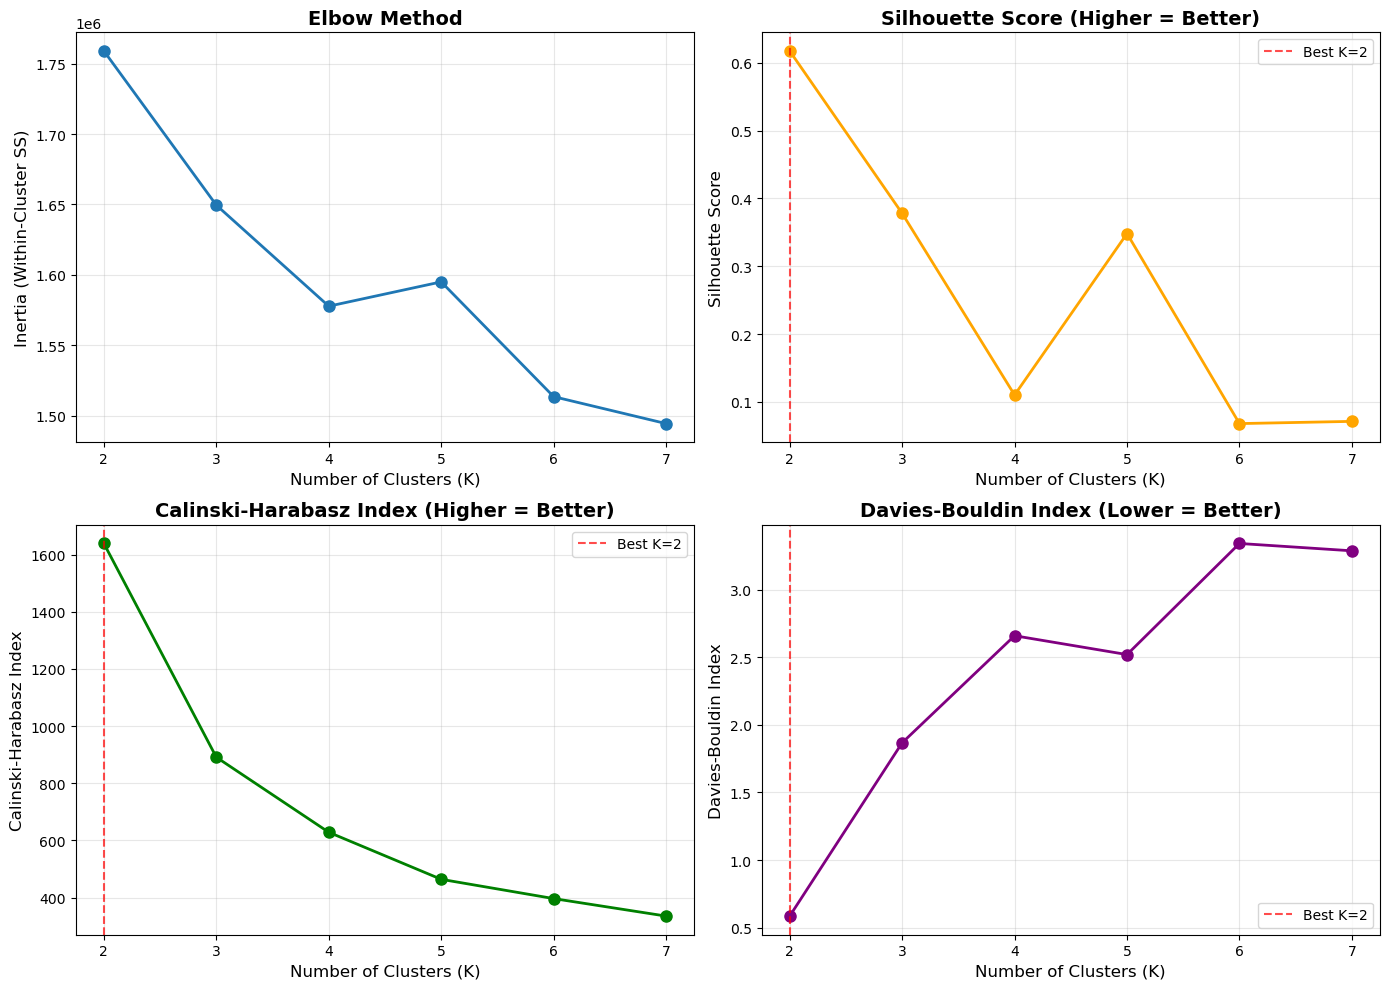

In [5]:
# Visualize metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow method
ax = axes[0, 0]
ax.plot(metrics_df['K'], metrics_df['Inertia'], 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (K)', fontsize=12)
ax.set_ylabel('Inertia (Within-Cluster SS)', fontsize=12)
ax.set_title('Elbow Method', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Silhouette
ax = axes[0, 1]
ax.plot(metrics_df['K'], metrics_df['Silhouette'], 'o-', color='orange', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (K)', fontsize=12)
ax.set_ylabel('Silhouette Score', fontsize=12)
ax.set_title('Silhouette Score (Higher = Better)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
best_sil_k = metrics_df.loc[metrics_df['Silhouette'].idxmax(), 'K']
ax.axvline(best_sil_k, color='red', linestyle='--', alpha=0.7, label=f'Best K={int(best_sil_k)}')
ax.legend()

# Calinski-Harabasz
ax = axes[1, 0]
ax.plot(metrics_df['K'], metrics_df['Calinski-Harabasz'], 'o-', color='green', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (K)', fontsize=12)
ax.set_ylabel('Calinski-Harabasz Index', fontsize=12)
ax.set_title('Calinski-Harabasz Index (Higher = Better)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
best_ch_k = metrics_df.loc[metrics_df['Calinski-Harabasz'].idxmax(), 'K']
ax.axvline(best_ch_k, color='red', linestyle='--', alpha=0.7, label=f'Best K={int(best_ch_k)}')
ax.legend()

# Davies-Bouldin
ax = axes[1, 1]
ax.plot(metrics_df['K'], metrics_df['Davies-Bouldin'], 'o-', color='purple', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (K)', fontsize=12)
ax.set_ylabel('Davies-Bouldin Index', fontsize=12)
ax.set_title('Davies-Bouldin Index (Lower = Better)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
best_db_k = metrics_df.loc[metrics_df['Davies-Bouldin'].idxmin(), 'K']
ax.axvline(best_db_k, color='red', linestyle='--', alpha=0.7, label=f'Best K={int(best_db_k)}')
ax.legend()

plt.tight_layout()
plt.savefig(op.join(OUTPUT_DIR, 'clustering_metrics.png'), dpi=150, bbox_inches='tight')
plt.show()

#### Comment

Given the output of the four different methods, the best choice is k=2. The Silhouette Score, CH and DB indexes all suggest k=2 (maximum score) while from the elbow method, in this particular case, it is not very clear, but it seems anyway to point at k=2 (maximum drop).

In [6]:
# Fit final model
optimal_k = 2
kmeans_final = KMeans(n_clusters=optimal_k)
cluster_labels = kmeans_final.fit_predict(fmri_masked)

print('\nCluster sizes:')
for i in range(optimal_k):
    count = np.sum(cluster_labels == i)
    pct = 100 * count / n_volumes
    print(f'  Cluster {i}: {count:3d} volumes ({pct:5.1f}%)')


Cluster sizes:
  Cluster 0: 284 volumes ( 50.0%)
  Cluster 1: 284 volumes ( 50.0%)


## Visualize centroids in axial view


Centroids shape: (2, 228552)
  (2 clusters × 228,552 voxels)
  Saved: centroid_cluster0.nii.gz
  Saved: centroid_cluster1.nii.gz


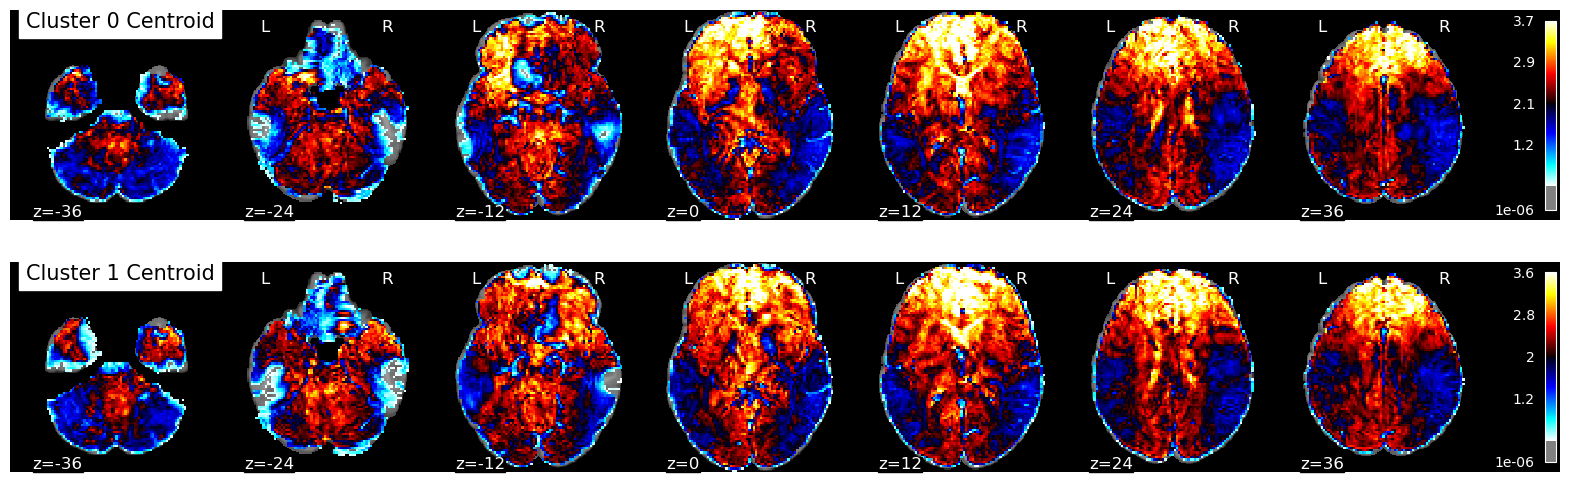

In [7]:
centroids = kmeans_final.cluster_centers_
print(f'\nCentroids shape: {centroids.shape}')
print(f'  ({centroids.shape[0]} clusters × {centroids.shape[1]:,} voxels)')

# Reconstruct centroids as 3D brain images
centroid_imgs = []
for i in range(optimal_k):
    centroid_3d = masker.inverse_transform(centroids[i:i+1])
    centroid_imgs.append(centroid_3d)
    nii_path = op.join(OUTPUT_DIR, f'centroid_cluster{i}.nii.gz')
    centroid_3d.to_filename(nii_path)
    print(f'  Saved: centroid_cluster{i}.nii.gz')


fig = plt.figure(figsize=(20, 3*optimal_k))
for i, centroid_img in enumerate(centroid_imgs):
    data = centroid_img.get_fdata()
    nonzero_data = data[data != 0]
    if len(nonzero_data) > 0:
        vmin, vmax = np.percentile(nonzero_data, [2, 98])
    else:
        vmin, vmax = data.min(), data.max()
    
    # Create subplot for this cluster
    ax = plt.subplot(optimal_k, 1, i+1)
    
    # Plot with 7 axial slices
    plotting.plot_stat_map(
        centroid_img,
        bg_img=load_mni152_template(),
        display_mode='z',
        cut_coords=[-36, -24, -12, 0, 12, 24, 36],
        title=f'Cluster {i} Centroid',
        axes=ax,
        colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cmap='cold_hot',
        annotate=True
    )

plt.savefig(op.join(OUTPUT_DIR, f'centroids_axial_view_k{optimal_k}.png'), 
            dpi=150, bbox_inches='tight')
plt.show()

## Pairwise similarity using Pearson Coefficient

In [8]:
n_compare = 5
kmeans_5 = KMeans(n_clusters=n_compare)
_ = kmeans_5.fit_predict(fmri_masked)
centroids_5 = kmeans_5.cluster_centers_

Saved: /data/kmeans_results/similarity_pearson.png


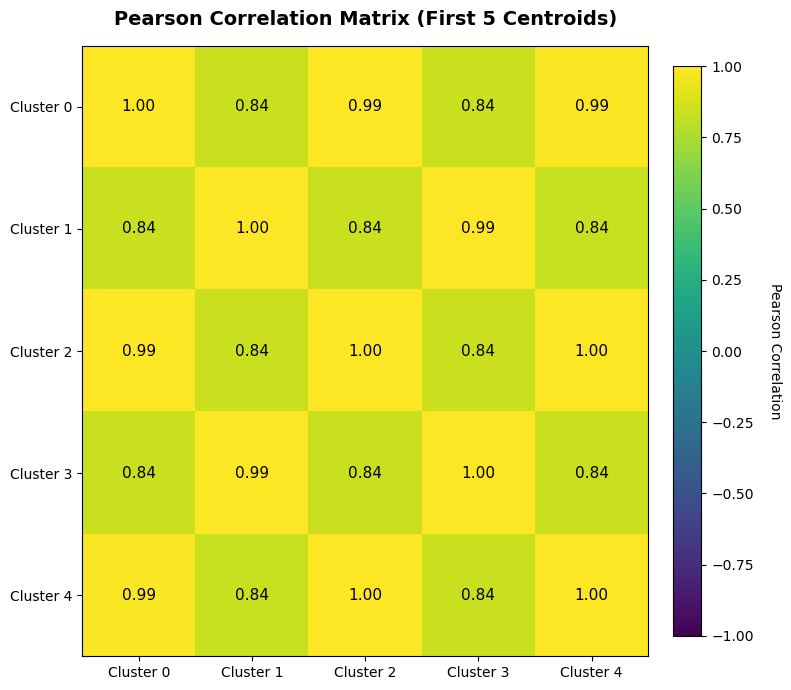

In [9]:
pearson_matrix = np.zeros((n_compare, n_compare))
for i in range(n_compare):
    for j in range(n_compare):
        if i == j:
            pearson_matrix[i, j] = 1.0
        else:
            corr, _ = pearsonr(centroids_5[i], centroids_5[j])
            pearson_matrix[i, j] = corr

fig, ax = plt.subplots(figsize=(8, 7))

im = ax.imshow(pearson_matrix, cmap='viridis', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(np.arange(n_compare))
ax.set_yticks(np.arange(n_compare))
ax.set_xticklabels([f'Cluster {i}' for i in range(n_compare)])
ax.set_yticklabels([f'Cluster {i}' for i in range(n_compare)])
ax.set_title(f'Pearson Correlation Matrix (First {n_compare} Centroids)', 
             fontsize=14, fontweight='bold', pad=15)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Pearson Correlation', rotation=270, labelpad=20)

# Add text annotations
for i in range(n_compare):
    for j in range(n_compare):
        text = ax.text(j, i, f'{pearson_matrix[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=11)

plt.tight_layout()
heatmap_path = op.join(OUTPUT_DIR, f'similarity_pearson.png')
plt.savefig(heatmap_path, dpi=150, bbox_inches='tight')
print(f'Saved: {heatmap_path}')
plt.show()